# Programming Assignment: 
## Готовим LDA по рецептам

Как вы уже знаете, в тематическом моделировании делается предположение о том, что для определения тематики порядок слов в документе не важен; об этом гласит гипотеза «мешка слов». Сегодня мы будем работать с несколько нестандартной для тематического моделирования коллекцией, которую можно назвать «мешком ингредиентов», потому что на состоит из рецептов блюд разных кухонь. Тематические модели ищут слова, которые часто вместе встречаются в документах, и составляют из них темы. Мы попробуем применить эту идею к рецептам и найти кулинарные «темы». Эта коллекция хороша тем, что не требует предобработки. Кроме того, эта задача достаточно наглядно иллюстрирует принцип работы тематических моделей.

Для выполнения заданий, помимо часто используемых в курсе библиотек, потребуются модули *json* и *gensim*. Первый входит в дистрибутив Anaconda, второй можно поставить командой 

*pip install gensim*

Построение модели занимает некоторое время. На ноутбуке с процессором Intel Core i7 и тактовой частотой 2400 МГц на построение одной модели уходит менее 10 минут.

### Загрузка данных

Коллекция дана в json-формате: для каждого рецепта известны его id, кухня (cuisine) и список ингредиентов, в него входящих. Загрузить данные можно с помощью модуля json (он входит в дистрибутив Anaconda):

In [1]:
import json

In [2]:
with open("recipes.json") as f:
    recipes = json.load(f)

In [3]:
print(recipes[0])

{'id': 10259, 'cuisine': 'greek', 'ingredients': ['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']}


### Составление корпуса

In [4]:
from gensim import corpora, models
import numpy as np

Наша коллекция небольшая, и целиком помещается в оперативную память. Gensim может работать с такими данными и не требует их сохранения на диск в специальном формате. Для этого коллекция должна быть представлена в виде списка списков, каждый внутренний список соответствует отдельному документу и состоит из его слов. Пример коллекции из двух документов: 

[["hello", "world"], ["programming", "in", "python"]]

Преобразуем наши данные в такой формат, а затем создадим объекты corpus и dictionary, с которыми будет работать модель.

In [5]:
texts = [recipe["ingredients"] for recipe in recipes]
dictionary = corpora.Dictionary(texts)   # составляем словарь
corpus = [dictionary.doc2bow(text) for text in texts]  # составляем корпус документов

In [6]:
print(texts[0])
print(corpus[0])

['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


У объекта dictionary есть полезная переменная dictionary.token2id, позволяющая находить соответствие между ингредиентами и их индексами.

### Обучение модели
Вам может понадобиться [документация](https://radimrehurek.com/gensim/models/ldamodel.html) LDA в gensim.

__Задание 1.__ Обучите модель LDA с 40 темами, установив количество проходов по коллекции 5 и оставив остальные параметры по умолчанию. 


Затем вызовите метод модели *show_topics*, указав количество тем 40 и количество токенов 10, и сохраните результат (топы ингредиентов в темах) в отдельную переменную. Если при вызове метода *show_topics* указать параметр *formatted=True*, то топы ингредиентов будет удобно выводить на печать, если *formatted=False*, будет удобно работать со списком программно. Выведите топы на печать, рассмотрите темы, а затем ответьте на вопрос:

Сколько раз ингредиенты "salt", "sugar", "water", "mushrooms", "chicken", "eggs" встретились среди топов-10 всех 40 тем? При ответе __не нужно__ учитывать составные ингредиенты, например, "hot water".

Передайте 6 чисел в функцию save_answers1 и загрузите сгенерированный файл в форму.

У gensim нет возможности фиксировать случайное приближение через параметры метода, но библиотека использует numpy для инициализации матриц. Поэтому, по утверждению автора библиотеки, фиксировать случайное приближение нужно командой, которая написана в следующей ячейке. __Перед строкой кода с построением модели обязательно вставляйте указанную строку фиксации random.seed.__

In [7]:
np.random.seed(76543)
# здесь код для построения модели:
from gensim.models import LdaModel

model = LdaModel(corpus, num_topics=40, passes=5)

In [8]:
topics = model.show_topics(num_topics=40, num_words=10, formatted=False)

In [9]:
topics_words = []

for i, topic in enumerate(topics):
    topics_words.append([dictionary[int(token[0])] for token in topic[1]]) 

In [10]:
from collections import Counter

top_words = [word for topic in topics_words for word in topic]
words_counter = Counter(top_words)

In [11]:
def save_answers1(c_salt, c_sugar, c_water, c_mushrooms, c_chicken, c_eggs):
    with open("cooking_LDA_pa_task1.txt", "w") as fout:
        fout.write(" ".join([str(el) for el in [c_salt, c_sugar, c_water, c_mushrooms, c_chicken, c_eggs]]))

In [12]:
save_answers1(words_counter['salt'], words_counter['sugar'], \
              words_counter['water'], words_counter['mushrooms'], \
              words_counter['chicken'], words_counter['eggs'])

In [13]:
{word : words_counter[word] for word in ['salt', 'sugar', 'water', 'mushrooms','chicken', 'eggs']}

{'salt': 23, 'sugar': 9, 'water': 10, 'mushrooms': 0, 'chicken': 1, 'eggs': 2}

### Фильтрация словаря
В топах тем гораздо чаще встречаются первые три рассмотренных ингредиента, чем последние три. При этом наличие в рецепте курицы, яиц и грибов яснее дает понять, что мы будем готовить, чем наличие соли, сахара и воды. Таким образом, даже в рецептах есть слова, часто встречающиеся в текстах и не несущие смысловой нагрузки, и поэтому их не желательно видеть в темах. Наиболее простой прием борьбы с такими фоновыми элементами — фильтрация словаря по частоте. Обычно словарь фильтруют с двух сторон: убирают очень редкие слова (в целях экономии памяти) и очень частые слова (в целях повышения интерпретируемости тем). Мы уберем только частые слова.

In [14]:
import copy
dictionary2 = copy.deepcopy(dictionary)

__Задание 2.__ У объекта dictionary2 есть переменная *dfs* — это словарь, ключами которого являются id токена, а элементами — число раз, сколько слово встретилось во всей коллекции. Сохраните в отдельный список ингредиенты, которые встретились в коллекции больше 4000 раз. Вызовите метод словаря *filter_tokens*, подав в качестве первого аргумента полученный список популярных ингредиентов. Вычислите две величины: dict_size_before и dict_size_after — размер словаря до и после фильтрации.

Затем, используя новый словарь, создайте новый корпус документов, corpus2, по аналогии с тем, как это сделано в начале ноутбука. Вычислите две величины: corpus_size_before и corpus_size_after — суммарное количество ингредиентов в корпусе (для каждого документа вычислите число различных ингредиентов в нем и просуммируйте по всем документам) до и после фильтрации.

Передайте величины dict_size_before, dict_size_after, corpus_size_before, corpus_size_after в функцию save_answers2 и загрузите сгенерированный файл в форму.

In [15]:
dict_size_before = len(dictionary2)

print(f"Dict size before: {dict_size_before}")

Dict size before: 6714


In [16]:
filtered_dict = [item[0] for item in dictionary2.dfs.items() if item[1] > 4000]

In [17]:
dictionary2.filter_tokens(bad_ids=filtered_dict)

dict_size_after = len(dictionary2)
print(f"Dict size after: {dict_size_after}")

Dict size after: 6702


In [18]:
corpus2 = [dictionary2.doc2bow(text) for text in texts]

In [19]:
def get_corpus_size(corpus):
    result = 0
    for item in corpus:
        result += len(item)
    return result

In [20]:
corpus_size_before = get_corpus_size(corpus)
corpus_size_after = get_corpus_size(corpus2)

print(f"Corpus size before: {corpus_size_before}")
print(f"Corpus size after: {corpus_size_after}")

Corpus size before: 428249
Corpus size after: 343665


In [21]:
def save_answers2(dict_size_before, dict_size_after, corpus_size_before, corpus_size_after):
    with open("cooking_LDA_pa_task2.txt", "w") as fout:
        fout.write(" ".join([str(el) for el in [dict_size_before, dict_size_after, corpus_size_before, corpus_size_after]]))

save_answers2(dict_size_before, dict_size_after, corpus_size_before, corpus_size_after)

### Сравнение когерентностей
__Задание 3.__ Постройте еще одну модель по корпусу corpus2 и словарю dictionary2, остальные параметры оставьте такими же, как при первом построении модели. Сохраните новую модель в другую переменную (не перезаписывайте предыдущую модель). Не забудьте про фиксирование seed!

Затем воспользуйтесь методом *top_topics* модели, чтобы вычислить ее когерентность. Передайте в качестве аргумента соответствующий модели корпус. Метод вернет список кортежей (топ токенов, когерентность), отсортированных по убыванию последней. Вычислите среднюю по всем темам когерентность для каждой из двух моделей и передайте в функцию save_answers3. 

In [22]:
np.random.seed(76543)

model2 = LdaModel(corpus2, num_topics=40, passes=5)

In [23]:
def get_coherences(model, corpus, dictionary):
    return np.array([item[1] for item in model.top_topics(corpus, dictionary=dictionary)])

coherences = get_coherences(model, corpus, dictionary)
coherences2 = get_coherences(model2, corpus2, dictionary2)

In [24]:
print(f"Coherence: {coherences.mean()}")
print(f"Coherence2: {coherences2.mean()}")

Coherence: -5.839332585536563
Coherence2: -8.304104910059582


In [25]:
def save_answers3(coherence, coherence2):
    with open("cooking_LDA_pa_task3.txt", "w") as fout:
        fout.write(" ".join(["%3f"%el for el in [coherence, coherence2]]))
        
save_answers3(coherences.mean(), coherences2.mean())

Считается, что когерентность хорошо соотносится с человеческими оценками интерпретируемости тем. Поэтому на больших текстовых коллекциях когерентность обычно повышается, если убрать фоновую лексику. Однако в нашем случае этого не произошло. 

### Изучение влияния гиперпараметра alpha

В этом разделе мы будем работать со второй моделью, то есть той, которая построена по сокращенному корпусу. 

Пока что мы посмотрели только на матрицу темы-слова, теперь давайте посмотрим на матрицу темы-документы. Выведите темы для нулевого (или любого другого) документа из корпуса, воспользовавшись методом *get_document_topics* второй модели:

In [26]:
model2.get_document_topics(corpus2[0])

[(25, 0.128125), (30, 0.13388853), (31, 0.6223615)]

Также выведите содержимое переменной *.alpha* второй модели:

In [27]:
model2.alpha

array([0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025], dtype=float32)

У вас должно получиться, что документ характеризуется небольшим числом тем. Попробуем поменять гиперпараметр alpha, задающий априорное распределение Дирихле для распределений тем в документах.

__Задание 4.__ Обучите третью модель: используйте сокращенный корпус (corpus2 и dictionary2) и установите параметр __alpha=1__, passes=5. Не забудьте про фиксацию seed! Выведите темы новой модели для нулевого документа; должно получиться, что распределение над множеством тем практически равномерное. Чтобы убедиться в том, что во второй модели документы описываются гораздо более разреженными распределениями, чем в третьей, посчитайте суммарное количество элементов, __превосходящих 0.01__, в матрицах темы-документы обеих моделей. Другими словами, запросите темы  модели для каждого документа с параметром *minimum_probability=0.01* и просуммируйте число элементов в получаемых массивах. Передайте две суммы (сначала для модели с alpha по умолчанию, затем для модели в alpha=1) в функцию save_answers4.

In [28]:
np.random.seed(76543)

model3 = LdaModel(corpus2, num_topics=40, passes=5, alpha=1)

In [29]:
def get_model_top_topic_count(model, corpus):
    result = 0
    for text in corpus:
        result += len(model.get_document_topics(text, minimum_probability=0.01))
    return result

m2ttc = get_model_top_topic_count(model2, corpus2)
m3ttc = get_model_top_topic_count(model3, corpus2)

In [30]:
print(f"Model2 count: {m2ttc}")
print(f"Model3 count: {m3ttc}")

Model2 count: 198232
Model3 count: 1590960


In [31]:
def save_answers4(count_model2, count_model3):
    with open("cooking_LDA_pa_task4.txt", "w") as fout:
        fout.write(" ".join([str(el) for el in [count_model2, count_model3]]))
        
save_answers4(m2ttc, m3ttc)

Таким образом, гиперпараметр __alpha__ влияет на разреженность распределений тем в документах. Аналогично гиперпараметр __eta__ влияет на разреженность распределений слов в темах.

### LDA как способ понижения размерности
Иногда, распределения над темами, найденные с помощью LDA, добавляют в матрицу объекты-признаки как дополнительные, семантические, признаки, и это может улучшить качество решения задачи. Для простоты давайте просто обучим классификатор рецептов на кухни на признаках, полученных из LDA, и измерим точность (accuracy).

__Задание 5.__ Используйте модель, построенную по сокращенной выборке с alpha по умолчанию (вторую модель). Составьте матрицу $\Theta = p(t|d)$ вероятностей тем в документах; вы можете использовать тот же метод get_document_topics, а также вектор правильных ответов y (в том же порядке, в котором рецепты идут в переменной recipes). Создайте объект RandomForestClassifier со 100 деревьями, с помощью функции cross_val_score вычислите среднюю accuracy по трем фолдам (перемешивать данные не нужно) и передайте в функцию save_answers5.

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [33]:
theta = np.zeros((len(corpus2), 40))
for i, bow in enumerate(corpus2):
    for j, probability in model2.get_document_topics(bow):
        theta[i, j] = probability

y = [recipe['cuisine'] for recipe in recipes]

In [34]:
rfc = RandomForestClassifier(n_estimators=100)

In [35]:
accuracy = cross_val_score(rfc, theta, y, cv=3).mean()

print(accuracy)

0.5551365213456028


In [36]:
def save_answers5(accuracy):
     with open("cooking_LDA_pa_task5.txt", "w") as fout:
        fout.write(str(accuracy))
        
save_answers5(accuracy)

Для такого большого количества классов это неплохая точность. Вы можете попроовать обучать RandomForest на исходной матрице частот слов, имеющей значительно большую размерность, и увидеть, что accuracy увеличивается на 10–15%. Таким образом, LDA собрал не всю, но достаточно большую часть информации из выборки, в матрице низкого ранга.

### LDA — вероятностная модель
Матричное разложение, использующееся в LDA, интерпретируется как следующий процесс генерации документов.

Для документа $d$ длины $n_d$:
1. Из априорного распределения Дирихле с параметром alpha сгенерировать распределение над множеством тем: $\theta_d \sim Dirichlet(\alpha)$
1. Для каждого слова $w = 1, \dots, n_d$:
    1. Сгенерировать тему из дискретного распределения $t \sim \theta_{d}$
    1. Сгенерировать слово из дискретного распределения $w \sim \phi_{t}$.
    
Подробнее об этом в [Википедии](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation).

В контексте нашей задачи получается, что, используя данный генеративный процесс, можно создавать новые рецепты. Вы можете передать в функцию модель и число ингредиентов и сгенерировать рецепт :)

In [37]:
def generate_recipe(model, num_ingredients):
    theta = np.random.dirichlet(model.alpha)
    for i in range(num_ingredients):
        t = np.random.choice(np.arange(model.num_topics), p=theta)
        topic = model.show_topic(t, topn=model.num_terms)
        topic_distr = [x[1] for x in topic]
        terms = [x[0] for x in topic]
        w = np.random.choice(terms,  p=topic_distr)
        print(w)

### Интерпретация построенной модели
Вы можете рассмотреть топы ингредиентов каждой темы. Большиснтво тем сами по себе похожи на рецепты; в некоторых собираются продукты одного вида, например, свежие фрукты или разные виды сыра.

Попробуем эмпирически соотнести наши темы с национальными кухнями (cuisine). Построим матрицу $A$ размера темы $x$ кухни, ее элементы $a_{tc}$ — суммы $p(t|d)$ по всем документам $d$, которые отнесены к кухне $c$. Нормируем матрицу на частоты рецептов по разным кухням, чтобы избежать дисбаланса между кухнями. Следующая функция получает на вход объект модели, объект корпуса и исходные данные и возвращает нормированную матрицу $A$. Ее удобно визуализировать с помощью seaborn.

In [38]:
import pandas
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

In [39]:
def compute_topic_cuisine_matrix(model, corpus, recipes):
    # составляем вектор целевых признаков
    targets = list(set([recipe["cuisine"] for recipe in recipes]))
    # составляем матрицу
    tc_matrix = pandas.DataFrame(data=np.zeros((model.num_topics, len(targets))), columns=targets)
    for recipe, bow in zip(recipes, corpus):
        recipe_topic = model.get_document_topics(bow)
        for t, prob in recipe_topic:
            tc_matrix[recipe["cuisine"]][t] += prob
    # нормируем матрицу
    target_sums = pandas.DataFrame(data=np.zeros((1, len(targets))), columns=targets)
    for recipe in recipes:
        target_sums[recipe["cuisine"]] += 1
    return pandas.DataFrame(tc_matrix.values/target_sums.values, columns=tc_matrix.columns)

In [40]:
def plot_matrix(tc_matrix):
    plt.figure(figsize=(10, 10))
    seaborn.heatmap(tc_matrix, square=True)

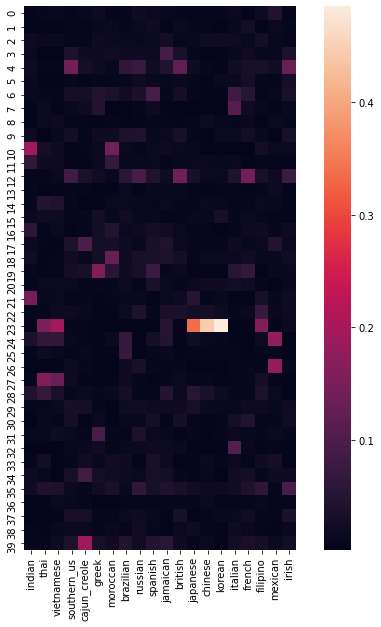

In [41]:
# Визуализируйте матрицу
plot_matrix(compute_topic_cuisine_matrix(model2, corpus2, recipes))

Чем темнее квадрат в матрице, тем больше связь этой темы с данной кухней. Мы видим, что у нас есть темы, которые связаны с несколькими кухнями. Такие темы показывают набор ингредиентов, которые популярны в кухнях нескольких народов, то есть указывают на схожесть кухонь этих народов. Некоторые темы распределены по всем кухням равномерно, они показывают наборы продуктов, которые часто используются в кулинарии всех стран. 

Жаль, что в датасете нет названий рецептов, иначе темы было бы проще интерпретировать...

### Заключение
В этом задании вы построили несколько моделей LDA, посмотрели, на что влияют гиперпараметры модели и как можно использовать построенную модель. 